# FYP - Midterm Presentation - Generalization of Classification Models
We use the data that was generated as follows:

1. 10 means $m_k$ were drawn from a bivariate Gaussian distribution $\mathcal{N}((1,0),I)$ and labeled *BLUE*.
2. 10 more were drawn from $\mathcal{N}((0,1),I)$ and labeled *ORANGE*.
3. For each class 100 observations were generated as follows:
  1. $m_k$ was picked at random with probability 1/10;
  2. observation was drawn from $\mathcal{N}(m_k,I/5)$, thus leading to a mixture of Gaussian clusters for each class.

The task is to create a classifier that, based on the coordinates, determines whether the point is *ORANGE* or *BLUE*. Of course, the classifier should not be based on then knowledge of how the data was generated.

In [97]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# numpy produces many warnings, we don't need them here
np.warnings.filterwarnings('ignore')

# define commonly used colors
BLACK, PURPLE = 'black', 'purple'
BLUE, ORANGE, BLUE1 = 'skyblue', 'sandybrown', '#174A7E'

# configure all plots font family and border line widths
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 0.5

In [98]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.mixture.gaussian_mixture import _compute_precision_cholesky
import pandas as pd

In [99]:
df = pd.read_csv("mixture.txt")
X_train = df[['x1', 'x2']].values
y_train = df.y.values

# set the known BLUE and ORANGE clusters means
blue_means = np.array([[-0.25343316, 1.7414788], [0.26669318, 0.3712341],
                       [2.09646921, 1.2333642], [-0.06127272, -0.2086791],
                       [2.70354085, 0.5968283], [2.37721198, -1.1864147],
                       [1.05690759, -0.6838939], [0.57888354, -0.0683458],
                       [0.62425213, 0.5987384], [1.67335495, -0.2893159]])
orange_means = np.array([[1.19936869, 0.2484086], [-0.30256110, 0.9454190],
                         [0.05727232, 2.4197271], [1.32932203, 0.8192260],
                         [-0.07938424, 1.6138017], [3.50792673, 1.0529863],
                         [1.61392290, 0.6717378], [1.00753570, 1.3683071],
                         [-0.45462141, 1.0860697], [-1.79801805, 1.9297806]])
all_means = np.vstack((blue_means, orange_means))

In [100]:
# even though we already know means and covariances, we need to
# do "fake fit", otherwise GaussianMixture model will not work
gaussian_mixture_model = GaussianMixture(
    n_components=20,
    covariance_type='spherical',
    means_init=all_means,
    random_state=1
).fit(all_means)
# set known covariances
gaussian_mixture_model.covariances_ = [1 / 5] * 20
# it looks like a hack, but GaussianMixture uses precisions_cholesky_
# for predict_proba method. Because we changed covariances_ we need
# to recalculate precisions_cholesky_ too.
gaussian_mixture_model.precisions_cholesky_ = _compute_precision_cholesky(
    gaussian_mixture_model.covariances_,
    gaussian_mixture_model.covariance_type)

In [101]:
# sample 10,000 points for testing
X_test, y_test = gaussian_mixture_model.sample(10000)
# y_test contains sampled component indices
# index < 10 means that the class is BLUE (0)
y_test = 1 * (y_test >= 10)

In [102]:
def optimal_bayes_predict(X):
    components_proba = gaussian_mixture_model.predict_proba(X)
    # first 10 components are BLUE(0), and others are BROWN(1)
    blue_proba = np.sum(components_proba[:, :10], axis=1)
    brown_proba = np.sum(components_proba[:, 10:], axis=1)
    y_hat = 1 * (blue_proba < brown_proba)
    return y_hat

In [103]:
bayes_error_rate = 1 - accuracy_score(y_test, optimal_bayes_predict(X_test))
print(f'The optimal Bayes error rate = {bayes_error_rate}')

The optimal Bayes error rate = 0.2148


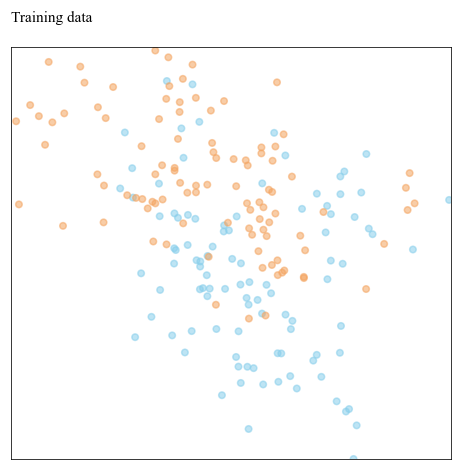

In [104]:
# prepares a plot with a title and circles representing training data
def plot_train_data(title):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=110)
    ax.set_aspect(1.3)
    ax.scatter(X_train[:, 0], X_train[:, 1], s=18, color=np.array([BLUE, ORANGE])[y_train], alpha=0.55)
    ax.tick_params(
        bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.set_xlim(-2.6, 4.2)
    ax.set_ylim(-2.0, 2.9)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.text(-2.6, 3.2, title, color=BLACK, fontsize=10)
    for spine in ax.spines.values():
        spine.set_color(BLACK)
    return fig, ax


# test it
_, _ = plot_train_data('Training data')

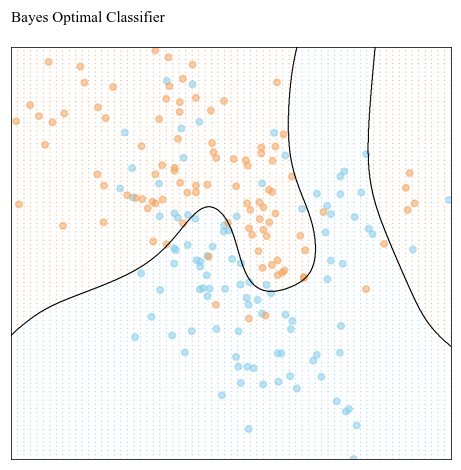

In [105]:
# given a model prediction function computes X points on n x n grid and the
# corresponding predicted classes
def fill_prediction_grid(n1, n2, predict):
    x1, x2 = np.linspace(-2.6, 4.2, n1), np.linspace(-2.0, 2.9, n2)
    X = np.transpose([np.tile(x1, n2), np.repeat(x2, n1)])
    y = predict(X)
    return X, y


# given a model prediction function computes X0 and X1 n x n meshgrids
# and the corresponing predicted classes meshgrid
def fill_prediction_meshgrid(predict):
    n1, n2 = 1000, 1000
    X, y = fill_prediction_grid(n1, n2, predict)
    return X[:, 0].reshape(n1, n2), X[:, 1].reshape(n1, n2), y.reshape(n1, n2)


# given a model prediction function plots train data, model decision
# bounary and background dots
def plot_model(predict, title):
    fig, ax = plot_train_data(title)
    # plot background dots
    X, y = fill_prediction_grid(69, 99, predict)
    ax.scatter(X[:, 0], X[:, 1], marker='.', lw=0, s=2,
               c=np.array([BLUE, ORANGE])[y])
    # plot the decision boundary
    X0, X1, Y = fill_prediction_meshgrid(predict)
    ax.contour(X0, X1, Y, [0.5], colors=BLACK, linewidths=[0.7])
    return fig, ax


# plot the optimal Bayes decision boundary
_, _ = plot_model(optimal_bayes_predict, 'Bayes Optimal Classifier')

In [106]:
# lets save Bayes meshgrids for optimal decision boundary plotting
X0_bayes, X1_bayes, Y_bayes = fill_prediction_meshgrid(optimal_bayes_predict)


# given a model prediction function plots performance statistics
def plot_model_stat(predict, title):
    fig, ax = plot_model(predict, title)
    ax.contour(X0_bayes, X1_bayes, Y_bayes, [0.5], colors='purple',
               linewidths=[0.5], linestyles='dashed')
    test_error_rate = 1 - accuracy_score(y_test, predict(X_test))
    train_error_rate = 1 - accuracy_score(y_train, predict(X_train))
    parms = {'color': BLACK, 'fontsize': 9,
             'bbox': {'facecolor': 'white', 'pad': 3, 'edgecolor': 'none'}}
    ax.text(-2.5, -1.41, f'Training Error: {train_error_rate:.3f}', **parms)
    ax.text(-2.5, -1.66, f'Test Error:       {test_error_rate:.3f}', **parms)
    ax.text(-2.5, -1.91, f'Bayes Error:    {bayes_error_rate:.3f}', **parms)
    return fig, ax

In [107]:
from sklearn.linear_model import LinearRegression

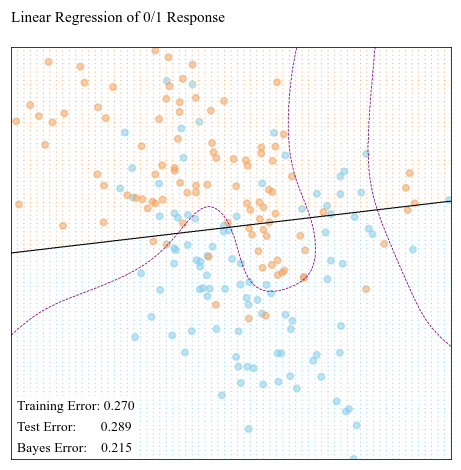

In [108]:
# Let’s look at an example of the linear model in a classification context.
linear_regression_model = LinearRegression().fit(X_train, y_train)


# The fitted values Y-hat are converted to a fitted class variable
# G-hat according to the rule G-hat = (ORANGE if Y-hat > 0.5, BLUE if
# Y-hat ≤ 0.5.
def linear_predict(X):
    return 1 * (linear_regression_model.predict(X) > 0.5)


# PAGE 13. The line is the decision boundary defined by x.T @ b = 0.5. The
#          orange shaded region denotes that part of input space classified as
#          ORANGE, while the blue region is classified as BLUE.
_, _ = plot_model_stat(linear_predict, 'Linear Regression of 0/1 Response')

In [109]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [110]:
# Run GridSearchCV to find the best n_neighbors parameter using the 10-folds
# CV. It finds 12, but if we selected the most parsimonious model within one
# standard error from the best model (one standard error rule), we will find 15.
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': list(range(1, 100))},
    cv=10
).fit(X_train, y_train)
print(k_neighbors_grid_search.best_params_)

{'n_neighbors': 12}


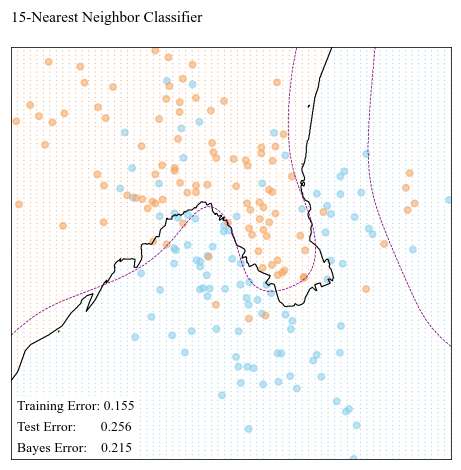

In [111]:
# Use 15-nearest-neighbor averaging of the binary coded response as
# the method of fitting. Thus Y-hat is the proportion of ORANGE’s in
# the neighborhood, and so assigning class ORANGE to G-hat if
# Y-hat>0.5 amounts to a majority vote in the neighborhood.
neighbors15_classifier = KNeighborsClassifier(
    n_neighbors=15
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors15_classifier.predict, '15-Nearest Neighbor Classifier')

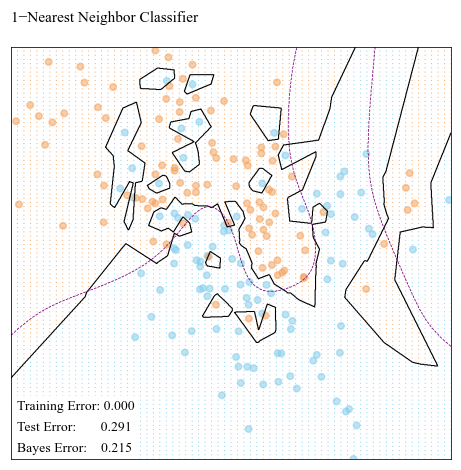

In [112]:
# The classes are coded as a binary variable (BLUE = 0,ORANGE = 1),
# and then predicted by 1-nearest-neighbor classification.
neighbors1_classifier = KNeighborsClassifier(
    n_neighbors=1
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors1_classifier.predict, '1−Nearest Neighbor Classifier')

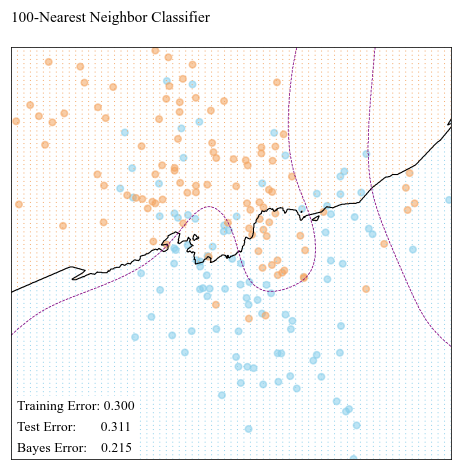

In [113]:
# Use 100-nearest-neighbor averaging of the binary coded response as
neighbors100_classifier = KNeighborsClassifier(
    n_neighbors=100
).fit(X_train, y_train)
_, _ = plot_model_stat(
    neighbors100_classifier.predict, '100-Nearest Neighbor Classifier')

In [114]:
n_neighbors_vals = list(range(1, 20)) + list(range(20, 101, 5))
k_neighbors_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': n_neighbors_vals},
    cv=10, scoring='accuracy',
    return_train_score=True, iid=True
).fit(X_train, y_train)
print(k_neighbors_grid_search.best_params_)

train_errors, test_errors = [], []
for k in n_neighbors_vals:
    clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    train_errors.append(1 - clf.score(X_train, y_train))
    test_errors.append(1 - clf.score(X_test, y_test))

{'n_neighbors': 12}


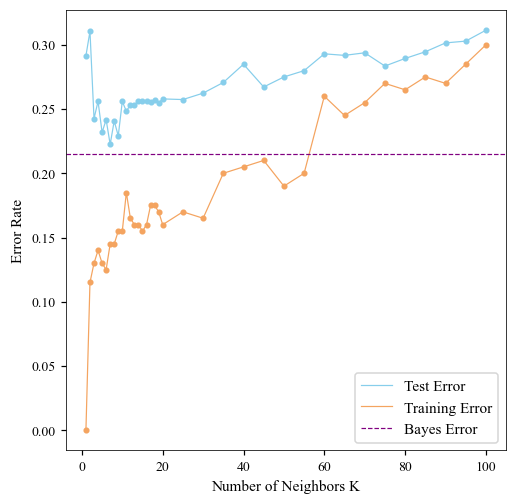

In [115]:
# k-nearest-neighbors on the two-class mixture data. The upper
# panel shows the misclassification errors as a function of
# neighborhood size. Standard error bars are included for 10-fold
# cross validation. The lower panel shows the decision boundary
# for 7-nearest-neighbors, which appears to be optimal for minimizing
# test error.

fig, ax = plt.subplots(figsize=(4, 4), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(n_neighbors_vals, test_errors, c=BLUE, s=9)
ax.plot(n_neighbors_vals, test_errors, c=BLUE, linewidth=0.8,
        label='Test Error')
ax.scatter(n_neighbors_vals, train_errors, c=ORANGE, s=9)
ax.plot(n_neighbors_vals, train_errors, c=ORANGE, linewidth=0.8,
        label='Training Error')
ax.axhline(y=bayes_error_rate, c=PURPLE, linewidth=0.8, linestyle='--',
           label='Bayes Error')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(9)
ax.set_xlabel('Number of Neighbors K', color=BLACK, fontsize=10)
ax.set_ylabel('Error Rate', color=BLACK, fontsize=10)
_ = ax.legend(loc='lower right', prop={'size': 10})

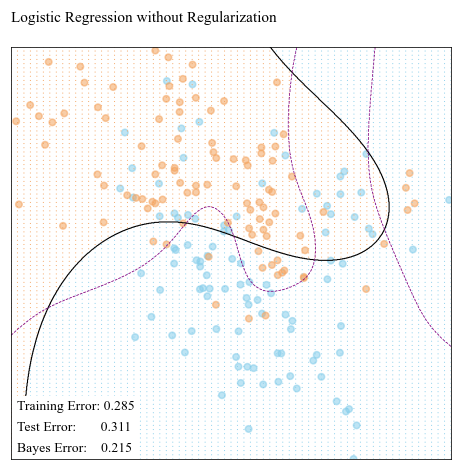

In [116]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

x1 = X_train[:, 0]
x2 = X_train[:, 1]
column_list = [x1, x2, x1 ** 2, x1 * x2, x2 ** 2, x1 ** 3, x1 ** 2 * x2, x1 * x2 ** 2, x2 ** 3]
def make_table(columnList):
    pd_column_list = []
    for column in columnList:
        pd_column = pd.DataFrame(column)
        pd_column_list.append(pd_column)
    table = pd.concat(pd_column_list, axis=1)
    return table

training_datatable = make_table(column_list)
trainingX = training_datatable.values

noRegularizationClassifier = LogisticRegression(random_state=0).fit(trainingX, y_train)

def noRegularizationClassifier_predict(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    column_list = [x1, x2, x1 ** 2, x1 * x2, x2 ** 2, x1 ** 3, x1 ** 2 * x2, x1 * x2 ** 2, x2 ** 3]
    datatable = make_table(column_list)
    convertedX = datatable.values
    return noRegularizationClassifier.predict(convertedX)

_, _ = plot_model_stat(
    noRegularizationClassifier_predict, 'Logistic Regression without Regularization')

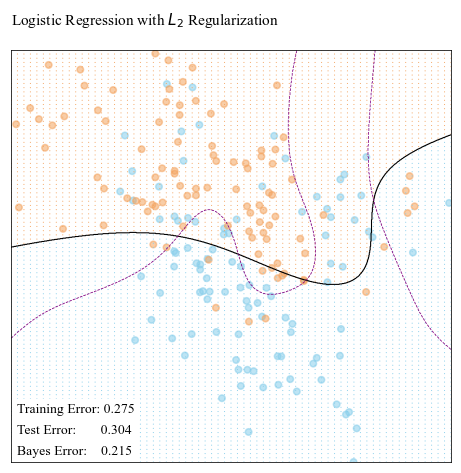

In [117]:
RegularizationClassifier = LogisticRegressionCV(cv=5, random_state=0).fit(trainingX, y_train)
def RegularizationClassifier_predict(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    column_list = [x1, x2, x1 ** 2, x1 * x2, x2 ** 2, x1 ** 3, x1 ** 2 * x2, x1 * x2 ** 2, x2 ** 3]
    datatable = make_table(column_list)
    convertedX = datatable.values
    return RegularizationClassifier.predict(convertedX)

_, _ = plot_model_stat(
    RegularizationClassifier_predict, 'Logistic Regression with $L_2$ Regularization')

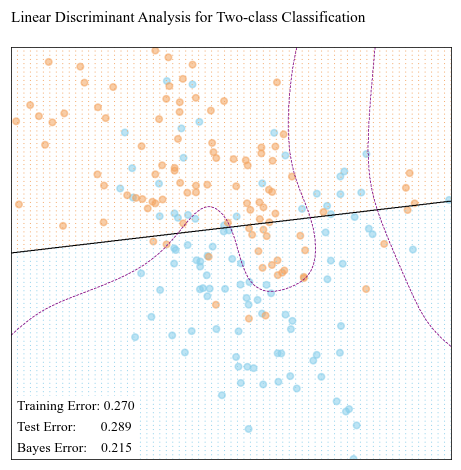

In [118]:
# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sklearn_lda = LDA(n_components=1)
X_lda_sklearn = sklearn_lda.fit_transform(X_train, y_train)
_, _ = plot_model_stat(
    sklearn_lda.predict, 'Linear Discriminant Analysis for Two-class Classification')

In [119]:
import math

feature_dict = {i: label for i, label in zip(
    range(4),
    ('sepal length in cm',
     'sepal width in cm',
     'petal length in cm',
     'petal width in cm',))}

df = pd.read_csv('iris.data', header=None)
df.columns = [l for i, l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True)  # to drop the empty line at file-end
print(df)
df.tail()

from sklearn.preprocessing import LabelEncoder

X = df[['sepal length in cm',
        'sepal width in cm',
        'petal length in cm',
        'petal width in cm']].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3: 'Virginica'}

     sepal length in cm  sepal width in cm  petal length in cm  \
0                   5.1                3.5                 1.4   
1                   4.9                3.0                 1.4   
2                   4.7                3.2                 1.3   
3                   4.6                3.1                 1.5   
4                   5.0                3.6                 1.4   
..                  ...                ...                 ...   
145                 6.7                3.0                 5.2   
146                 6.3                2.5                 5.0   
147                 6.5                3.0                 5.2   
148                 6.2                3.4                 5.4   
149                 5.9                3.0                 5.1   

     petal width in cm     class label  
0                  0.2     Iris-setosa  
1                  0.2     Iris-setosa  
2                  0.2     Iris-setosa  
3                  0.2     Iris-setosa  
4 

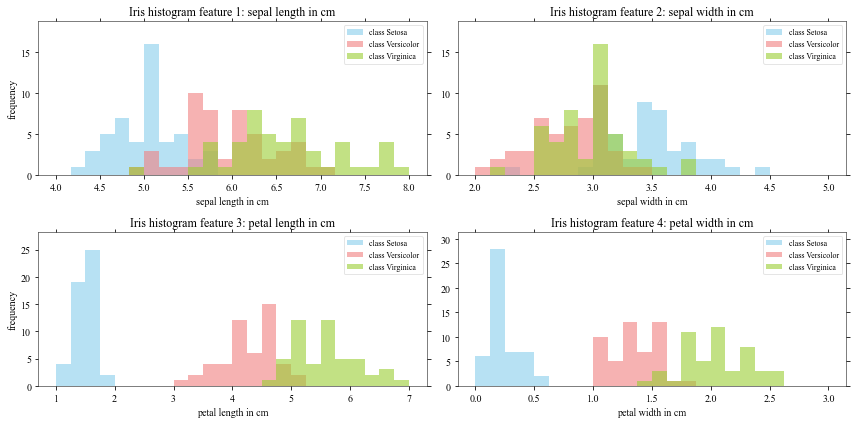

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
for ax, cnt in zip(axes.ravel(), range(4)):

    # set bin sizes
    min_b = math.floor(np.min(X[:, cnt]))
    max_b = math.ceil(np.max(X[:, cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab, col in zip(range(1, 4), ('skyblue', 'lightcoral', 'yellowgreen')):
        ax.hist(X[y == lab, cnt],
                color=col,
                label='class %s' % label_dict[lab],
                bins=bins,
                alpha=0.6, )
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims) + 2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram feature %s: %s' % (str(cnt + 1), feature_dict[cnt]))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",
                   labelbottom="on", left="off", right="off", labelleft="on")

axes[0][0].set_ylabel('frequency')
axes[1][0].set_ylabel('frequency')

fig.tight_layout()

plt.show()

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]
between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]

Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8844]
 [ 0.2854]
 [ 0.258 ]
 [ 0.2643]]
Eigenvalue 3: 3.42e-15

Eigenvector 4: 
[[-0.2234]
 [-0.2523]
 [-0.326 ]
 [ 0.8833]]
Eigenvalue 4: 1.15e-14

Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue

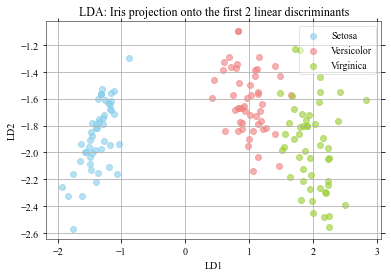

In [121]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4, 1), mv.reshape(4, 1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4, 1) # make column vector
    overall_mean = overall_mean.reshape(4, 1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

X_lda = W.T.dot(X.T)
assert X_lda.shape == (2, 150), "The matrix is not 150x2 dimensional."

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('o', 'o', 'o'),('skyblue', 'lightcoral', 'yellowgreen')):

        plt.scatter(x=X_lda[0, :].real[y == label],
                y=X_lda[1, :].real[y == label],
                marker=marker,
                color=color,
                alpha=0.6,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.6,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid(linestyle='-.')
    plt.tight_layout
    plt.show()

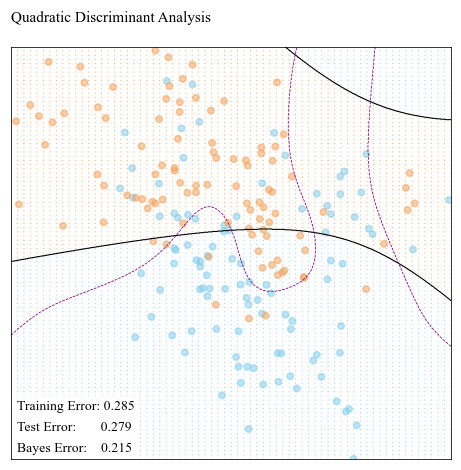

In [122]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
_, _ = plot_model_stat(
    clf.predict, 'Quadratic Discriminant Analysis')

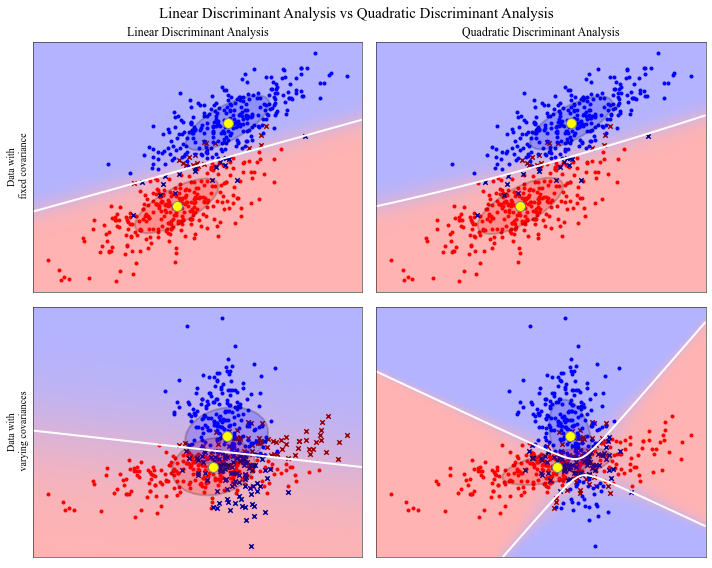

In [123]:
from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='yellow', markersize=10, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='yellow', markersize=10, markeredgecolor='grey')

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')


plt.figure(figsize=(10, 8), facecolor='white')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis',
             y=0.98, fontsize=15)
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()